In [253]:
import gym
import json 
import numpy as np 
import networkx
import matplotlib.pyplot as plt
import math
from math import sin, cos, radians, pi
from matplotlib import collections  as mc
import matplotlib.lines as mlines
%matplotlib inline

In [465]:
simpleGraph = networkx.Graph()

posA = [0, 0]
posB = [1, 1]
posC = [1, 2]
posD = [2, 2]
posE = [3, 3]
posF = [4, 4]
posG = [5, 5]
posZ = [7, 6]

simpleGraph.add_node("A", p = posA)
simpleGraph.add_node("B", p = posB)
simpleGraph.add_node("C", p = posC)
simpleGraph.add_node("D", p = posD)
simpleGraph.add_node("E", p = posE)
simpleGraph.add_node("F", p = posF)
simpleGraph.add_node("G", p = posG)
simpleGraph.add_node("Z", p = posZ)

simpleGraph.add_edge("A", "B")
simpleGraph.add_edge("A", "C")
simpleGraph.add_edge("B", "D")
simpleGraph.add_edge("C", "D")
simpleGraph.add_edge("D", "E")
simpleGraph.add_edge("A", "E")
simpleGraph.add_edge("E", "F")
simpleGraph.add_edge("E", "G")
simpleGraph.add_edge("G", "Z")

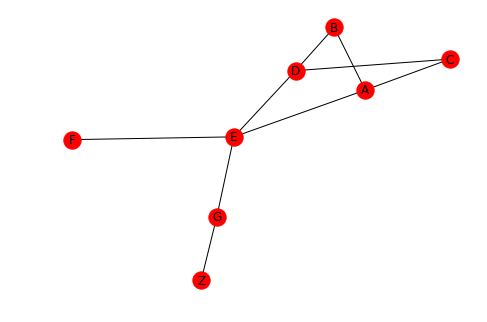

In [466]:

networkx.draw(simpleGraph, with_labels = True)
# networkx.draw_networkx_nodes(simpleGraph, pos=networkx.spring_layout(simpleGraph))
# networkx.draw_networkx_edges(simpleGraph, pos=networkx.spring_layout(simpleGraph))

# networkx.draw_networkx_labels(simpleGraph, pos=networkx.spring_layout(simpleGraph))
plt.show()

In [461]:

    
# def angleToPos(angle, x0, y0, radius=0.5):
#     rads = math.radians(angle) 
#     x = x0 + (radius * cos(rads))
#     y = x0 + (radius * sin(rads))
#     return (x, y)

def angleToPos(theta, x0, y0, d=0.5):
    theta_rad = radians(theta)
    return d*cos(theta_rad), d*sin(theta_rad)

In [467]:
def getNodeXY(node):
    return simpleGraph.node[node]["p"]

def getAngleToNextNode(nodeA, nodeB):
    posA = getNodeXY(nodeA)
    posB = getNodeXY(nodeB)
    paX = posA[0]
    paY = posA[1]
    pbX = posB[0]
    pbY = posB[1]
    rads = math.atan2(pbY-paY, pbX-paY)
    degs = math.degrees(rads)
    return degs

def getAnglesToNeighbors(node, referenceAngle):
    angles = []
    neighbors = simpleGraph.neighbors(node)
    for n in neighbors:
        d = getAngleToNextNode(node, n) - referenceAngle
        if d < -180:
            d = d + 360
        angles.append(d)
    return angles

for node in simpleGraph.nodes:
    simpleGraph.node[node]['connectionAngles'] = getAnglesToNeighbors(node, 0)
    
    

In [468]:


def actionFromAngle(angle):
    if angle == 0:
        return "STRAIGHT"
    elif angle > 0 and angle < 60:
        return "SLIGHT_LEFT"
    elif angle >=45 and angle < 120:
        return "LEFT"
    elif angle >= 120 and angle < 180:
        return "HARD_LEFT"
    elif angle == 180 or angle == -180:
        return "U_TURN"
    elif angle > -60 and angle < 0:
        return "SLIGHT_RIGHT"
    elif angle <= -60 and angle > -120:
        return "RIGHT"
    elif angle <= -120 and angle > -180:
        return "HARD_RIGHT"
    else:
        raise ValueError("invalid angle")





def getReferenceAngle(oldNode, newNode):
    return getAngleToNextNode(oldNode, newNode)

def getConnections(node):
    return list(simpleGraph.neighbors(node))


class Agent():
    def __init__(self, graph, initialNode, targetNode, facingAngle, verbose=True):
        self.atNode = initialNode
        self.targetNode = targetNode
        self.facing = facingAngle
        self.actions = []
        self.history = []
        self.coords = getNodeXY(initialNode)
        self.x = self.coords[0]
        self.y = self.coords[1]
        self.verbose = verbose
        self.graph = graph
        self.neighbors = getConnections(initialNode)
        self.getActions()
        self.action_space = ["STRAIGHT", "LEFT", "SLIGHT_LEFT", "HARD_LEFT", "U_TURN", "SLIGHT_RIGHT", "RIGHT", "HARD_RIGHT"]
        print self.actions
        self.connnectingAngles = getAnglesToNeighbors(self.atNode, self.facing)
        
    def moveToNode(self, toNode):
        neighbors = getConnections(self.atNode)
        if toNode not in neighbors:
            print "Move not allowed"
            return False
        _x = self.x
        _y = self.y
        self.facing = getReferenceAngle(self.atNode, toNode)
        self.atNode = toNode ## advance
        self.coords = getNodeXY(self.atNode)
        self.x = self.coords[0]
        self.y = self.coords[1]
        
        self.history.append([[_x, _y], [self.x, self.y]])
        self.neighbors = getConnections(toNode)
        self.connnectingAngles = getAnglesToNeighbors(self.atNode, self.facing)
        
        self.getActions()

        print "Moved to node: " + self.atNode
        print "Set reference angle to ", self.facing
        if self.verbose:
            self.drawWorld()
        return True 
    
    
    def getActions(self):
        _connectionAngles = getAnglesToNeighbors(self.atNode, self.facing)
        self.actions = [] ## reset
        for angle in _connectionAngles:
            action = actionFromAngle(angle)
            if self.verbose:
                print ("angle: ", angle, " --> ", action)

            self.actions.append(action)
    
    def drawWorld(self):
        ## init --> TODO: do this with self.graph
        pts = [posA, posB, posC, posD, posE, posF, posG, posZ]
        labs = ["A", "B", "C", "D", "E", "F", "G", "Z"]
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        
        ## labels 
        for i in range(0, len(labs)):
            plt.text(xs[i], ys[i], labs[i])
        plt.title("Simple graph in cartesian space")

        ## path history
        for segment in self.history:   
            ax = plt.gca()
            _x = (segment[0][0], segment[1][0])
            _y = (segment[0][1], segment[1][1])

            l = mlines.Line2D(_x, _y)
    
            ax.add_line(l)
        
        ## connected paths
        for node in self.graph.nodes:
            
            _source = self.graph.node[node]['p']
            _targets = self.graph.neighbors(node)
            for t in _targets:
                _target = self.graph.node[t]['p']

                ax = plt.gca()
                _x = (_source[0], _target[0])
                _y = (_source[1], _target[1])

                l = mlines.Line2D(_x, _y, color='gray')
                ax.add_line(l)

        ## node points
        plt.scatter(xs, ys)

        ## direction arrow 
        x1, y1 = angleToPos(self.facing, self.x, self.y)
        plt.arrow(self.x, self.y, x1, y1, color='red', zorder=10)
        plt.show()
        
    def turn(self, direction):
        if direction not in self.action_space:
            raise ValueError("Invalid action command")
        else:
            try:
                _actionIdx = self.actions.index(direction)
                _toNode = self.neighbors[_actionIdx]
                self.moveToNode(_toNode)
                return True
            except ValueError:
                return False ## negative reward would go here
            


('angle: ', -26.56505117707799, ' --> ', 'SLIGHT_RIGHT')
('angle: ', -45.0, ' --> ', 'SLIGHT_RIGHT')
('angle: ', -45.0, ' --> ', 'SLIGHT_RIGHT')
['SLIGHT_RIGHT', 'SLIGHT_RIGHT', 'SLIGHT_RIGHT']


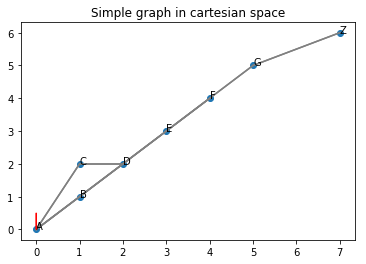

In [469]:
T = Agent(simpleGraph, "A", "Z", 90)
T.drawWorld()

In [470]:
T.turn("RIGHT")

False

In [471]:
T.turn("LEFT")

False

Moved to node: C
Set reference angle to  180.0




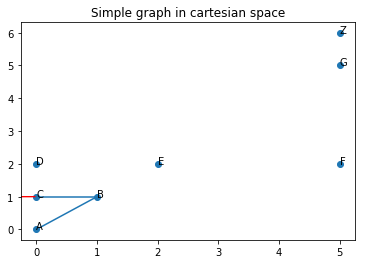

[45.0, -180.0, -45.0]


180.0

In [323]:
T.moveToNode("C")
T.turn("right")
T.facing

Moved to node: D
Set reference angle to  135.0





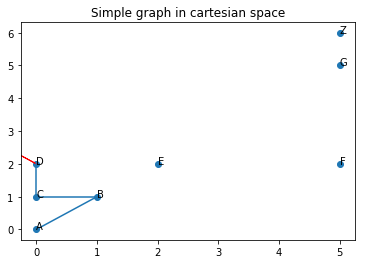

True

In [324]:
T.moveToNode("D")

[[[0, 0], [1, 1]], [[1, 1], [0, 1]], [[0, 1], [0, 2]], [[0, 2], [2, 2]]]
Moved to node: E
Set reference angle to  0.0
New Actions are:  None
[[0, 0], [1, 1]]






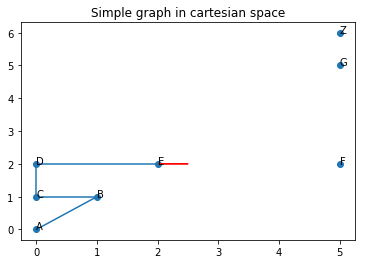

True

In [303]:
T.moveToNode("E")

[[[0, 0], [1, 1]], [[1, 1], [0, 1]], [[0, 1], [0, 2]], [[0, 2], [2, 2]], [[2, 2], [5, 5]]]
Moved to node: G
Set reference angle to  45.0
New Actions are:  None
[[0, 0], [1, 1]]







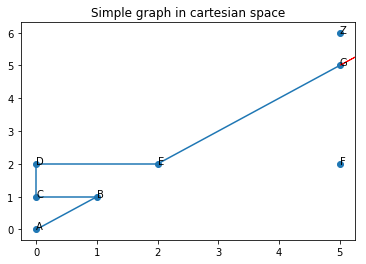

True

In [304]:
T.moveToNode("G")

[[[0, 0], [1, 1]], [[1, 1], [0, 1]], [[0, 1], [0, 2]], [[0, 2], [2, 2]], [[2, 2], [5, 5]], [[5, 5], [5, 6]]]
Moved to node: Z
Set reference angle to  90.0
New Actions are:  None
[[0, 0], [1, 1]]








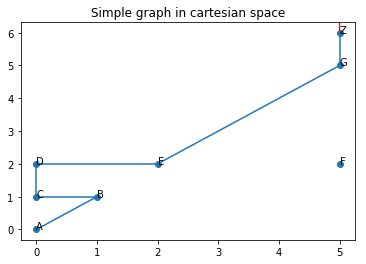

True

In [305]:
T.moveToNode("Z")